In [212]:
y_train.shape

(10976, 1)

In [215]:
def custom_loss(y_true, y_pred):
    """
    Custom loss function that combines L1 and L2 losses for the entire dataset with a flow rate equality loss.
    
    Parameters:
    y_true (tf.Tensor): True values of the target variable
    y_pred (tf.Tensor): Predicted values of the target variable
    
    Returns:
    tf.Tensor: Combined loss value
    """

    # Calculate the L1 and L2 losses for the entire dataset
    l1 = tf.reduce_mean(tf.abs(y_true - y_pred))
    l2 = tf.reduce_mean(tf.square(y_true - y_pred))

    # Calculate the flow rate equality loss
    #flow_rate_loss = tf.reduce_mean(tf.square(y_pred[:, 0] + y_pred[:, 1]- y_true[:,2]))

    #penalize values less than zero
    #z1 = tf.nn.relu(-y_pred[:,0])
    #z2 = tf.nn.relu(-y_pred[:,1])

    #penalize plug and slip flow for being too low
    #z3 = tf.reduce_mean(tf.nn.relu(y_true[:,1]-y_pred[:,1]))
    #z4 = tf.reduce_mean(tf.nn.relu(y_true[:,0]-y_pred[:,0]))
    
    # Combine the losses with appropriate weights
    total_loss =  l1+12 # + flow_rate_loss +z1 + z2 + 2*z3 +2*z4
    
    return total_loss

In [227]:
# Define the model architecture
model = keras.Sequential([
    layers.Dense(100, activation='relu', input_shape=(8,)), # Input layer
    layers.Dense(50, activation='relu'), # Hidden layer1
    layers.Dense(25, activation='relu'), # Hidden layer1
    layers.Dense(12, activation='relu'), # Hidden layer1
    layers.Dense(6, activation='relu'), # Hidden layer1
    layers.Dense(1) # No activation function for the output layer (linear activation function
])

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Train the model
history = model.fit(X_train, y_train, epochs=5, validation_data=(X_val, y_val), verbose=1)

# Evaluate the model
loss = model.evaluate(X_test, y_test)

# Make predictions
y_pred = model.predict(X_test)

Epoch 1/5
343/343 [==============================] - 2s 4ms/step - loss: 41.7145 - val_loss: 0.1181
Epoch 2/5
343/343 [==============================] - 1s 3ms/step - loss: 0.1101 - val_loss: 0.0788
Epoch 3/5
343/343 [==============================] - 1s 4ms/step - loss: 0.1348 - val_loss: 0.0763
Epoch 4/5
343/343 [==============================] - 1s 3ms/step - loss: 0.1063 - val_loss: 0.0580
Epoch 5/5
108/108 [==============================] - 0s 2ms/step


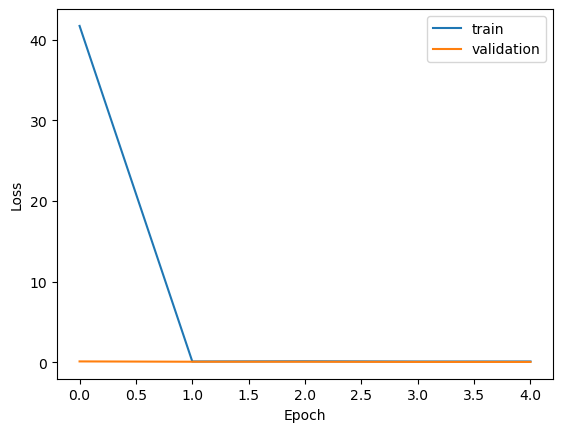

In [228]:
# Plot the loss
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.legend()
plt.show()

In [229]:
#turn the scaled data back into the original data
X_test_df = Xscaler.inverse_transform(X_test)
y_test_df = yscaler.inverse_transform(y_test)
y_pred_df = yscaler.inverse_transform(y_pred)


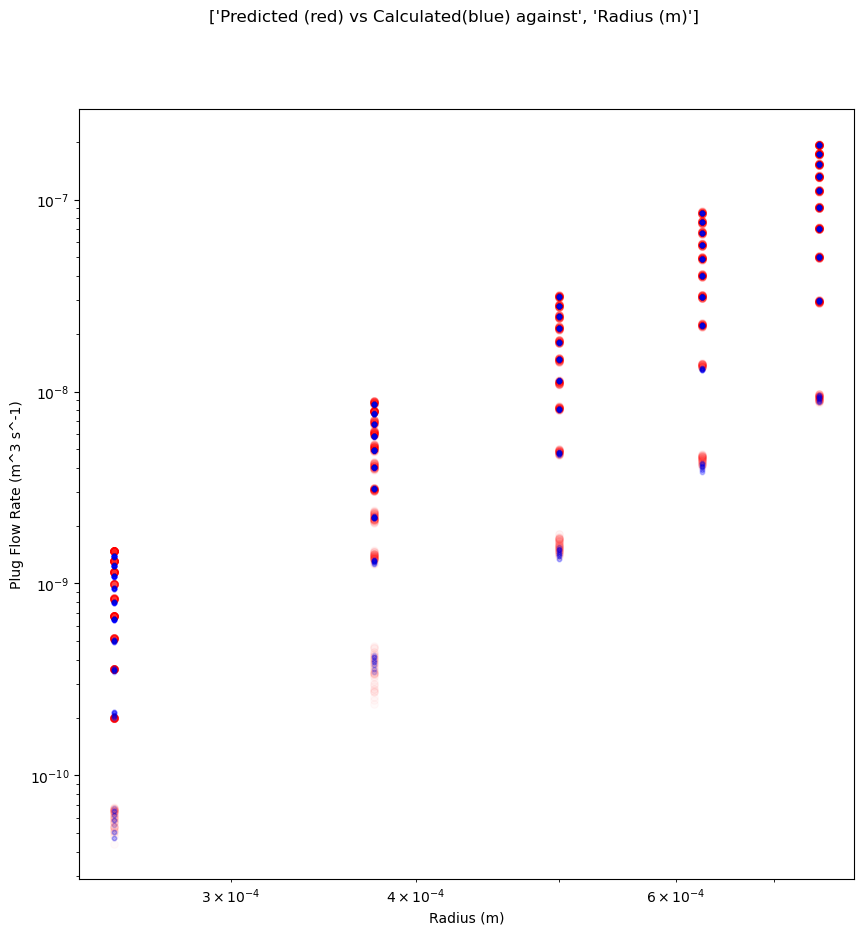

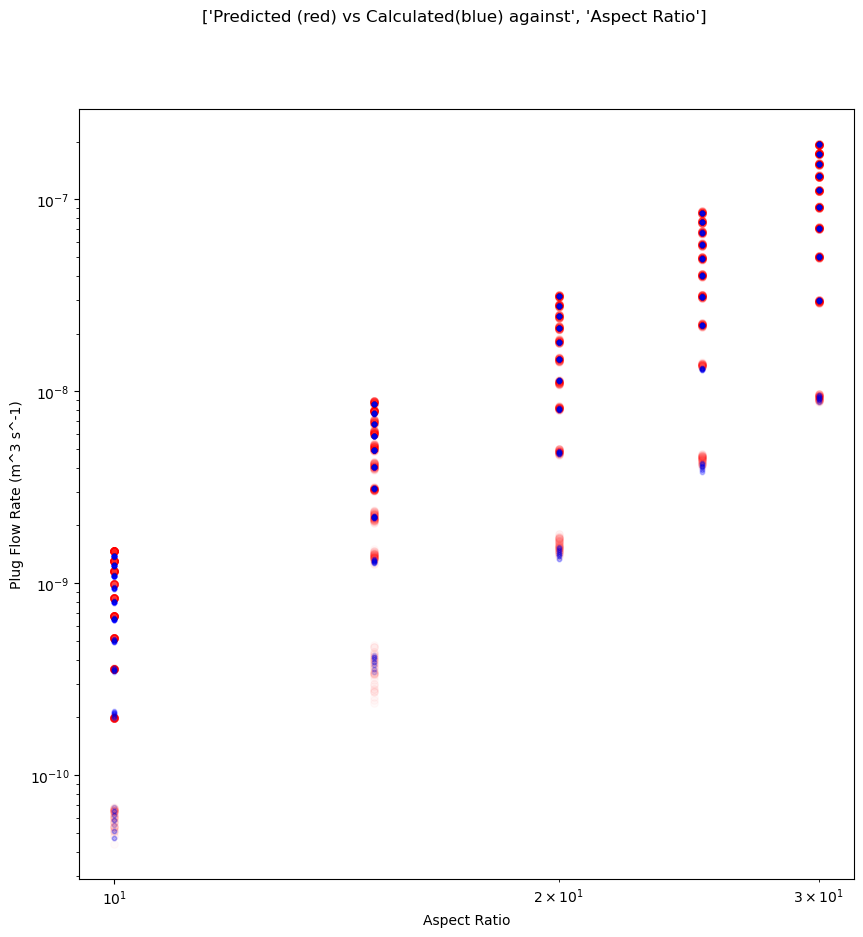

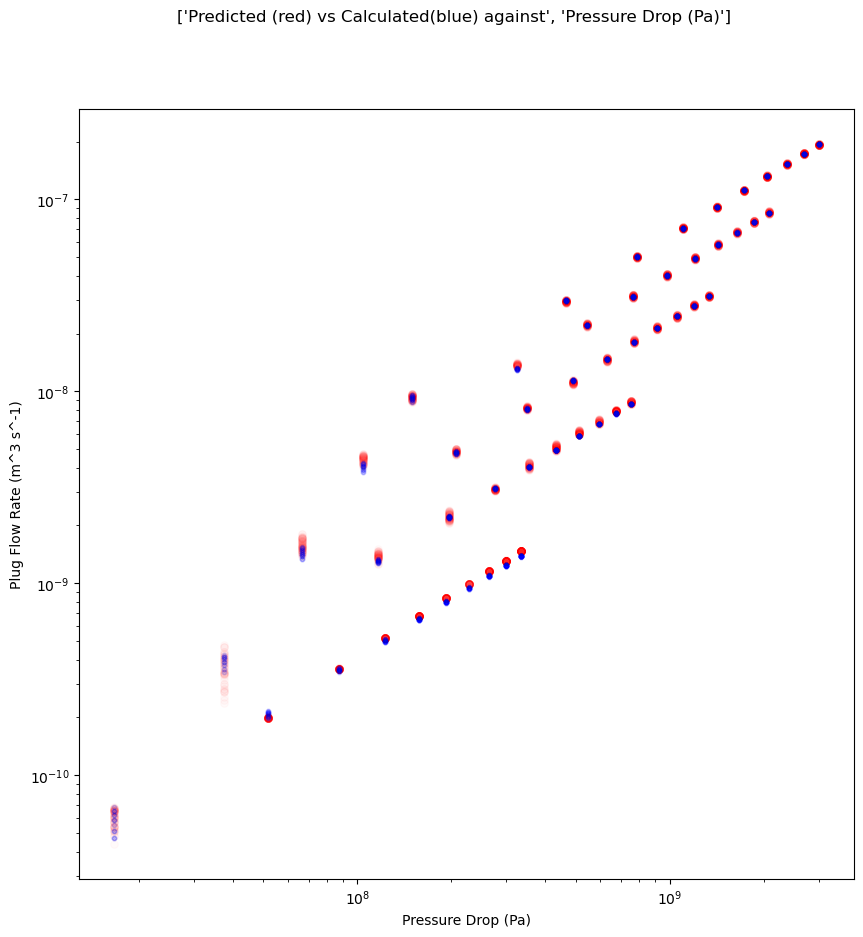

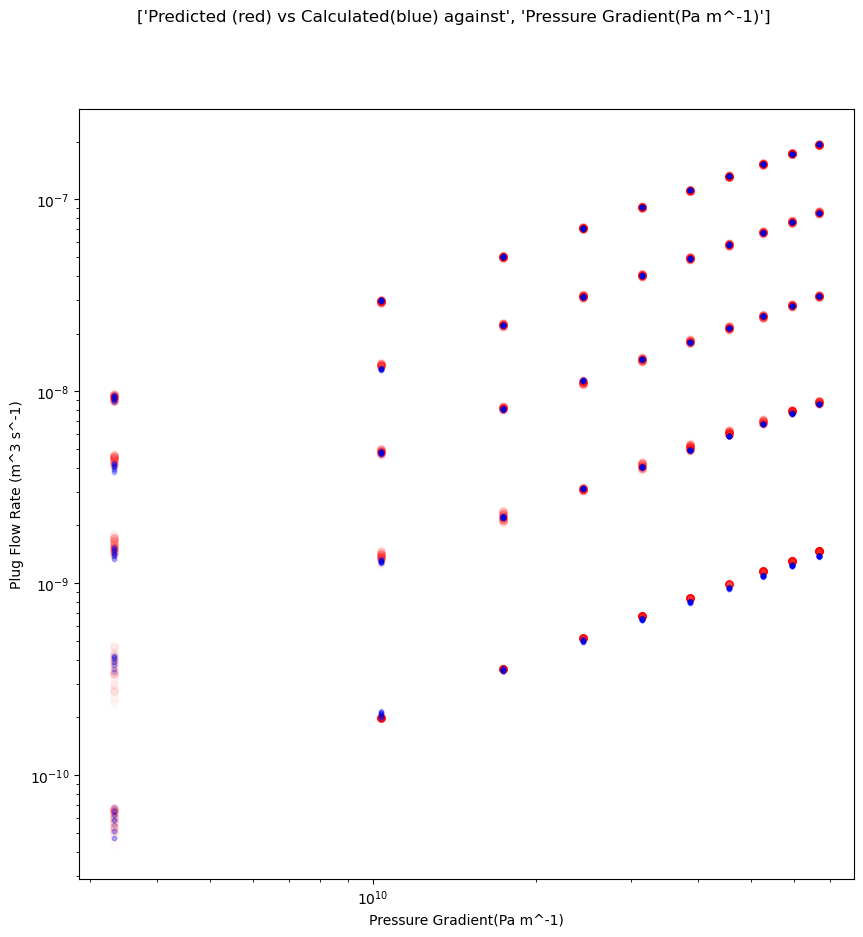

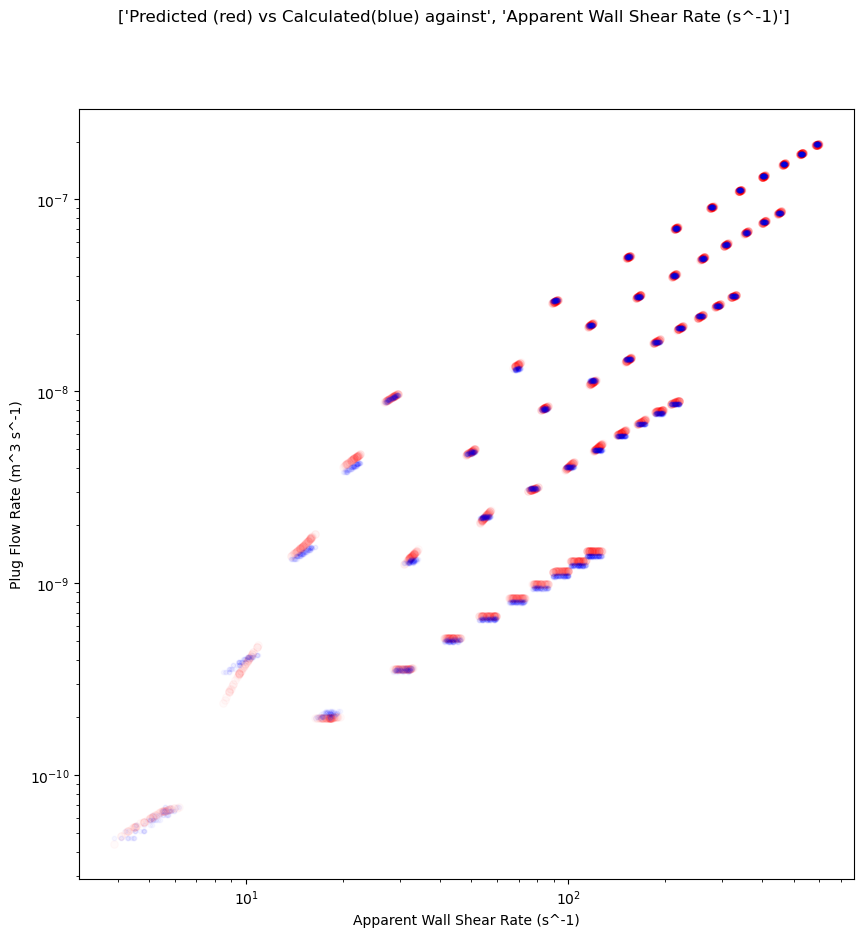

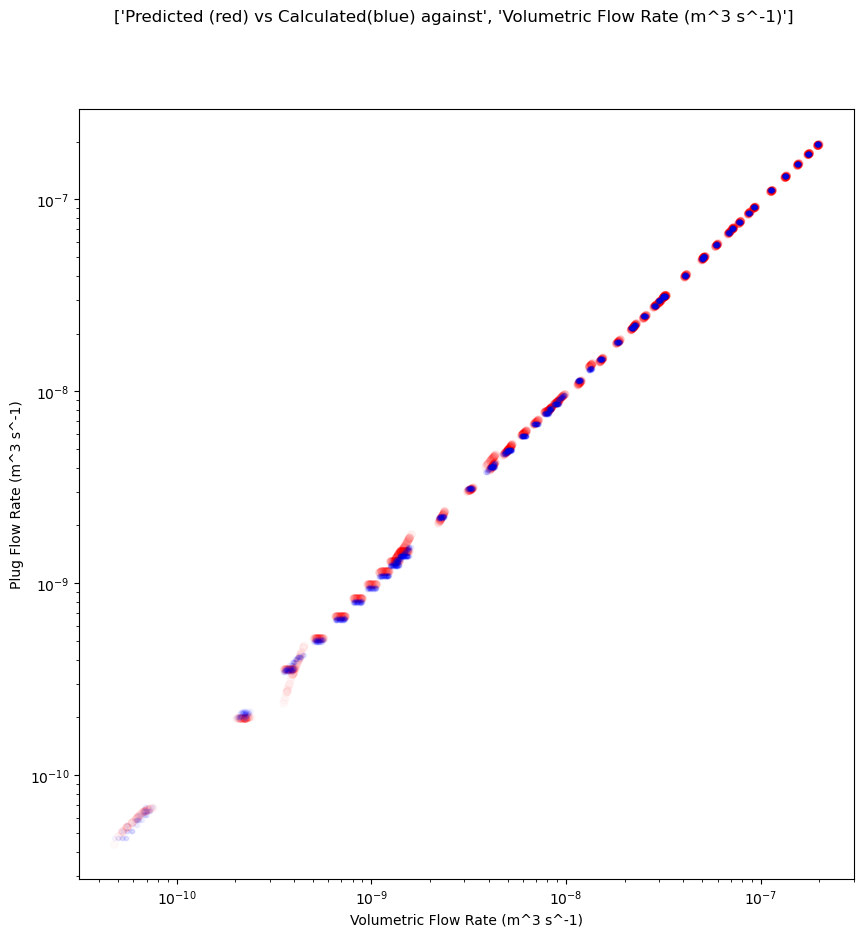

In [230]:
for k in range(6):
    counter = 0
    fig, axs = plt.subplots(1, 1, figsize=(10, 10), sharex=True)
    axs.scatter(X_test_df[:, k], y_pred_df[:, counter], alpha = 0.02, label = 'Predicted', color = 'red', s=30)
    axs.scatter(X_test_df[:, k], y_test_df[:, counter], alpha = 0.03, label = 'Calculated', color = 'blue', s=10)
    axs.set_ylabel(Target_Values.columns[counter])
    axs.set_xlabel(Theoretical_data.columns[k])
    axs.set_yscale('log')
    axs.set_xscale('log')
    counter = counter+1


    fig.suptitle(['Predicted (red) vs Calculated(blue) against', Theoretical_data.columns[k]])

In [139]:
#import the new target data into a pandas dataframe
Target_Values_2 = pd.read_csv('Target_Data_2.csv')

#look at the first few rows of the data
display(Target_Values_2.head())
print(Target_Values_2.shape)

,Yield Stress (Pa),Slip Yield Stress (Pa),Beta,Shear Thinning Index,Viscosity Consistency (Pa s^n)
0,10000.0,1000.0,1.000000e-10,0.6,900.000000
1,10000.0,1000.0,1.000000e-10,0.6,966.666667
2,10000.0,1000.0,1.000000e-10,0.6,1033.333333
3,10000.0,1000.0,1.000000e-10,0.6,1100.000000
4,10000.0,1000.0,1.000000e-10,0.6,1166.666667


(840350, 5)


In [140]:
#once the model is validated with the test data, we can use the model to predict values of Qslip and Qbulk for all the theoretical data

#First dropout the data that doesn't fit the model well
idx = Theoretical_data[Theoretical_data['Apparent Wall Shear Rate (s^-1)'] < 10].index
Theoretical_data = Theoretical_data.drop(idx)
Target_Values_2 = Target_Values_2.drop(idx)


#create temporary scalers
Xscaler_temp = MinMaxScaler(feature_range=(0, 100))
yscaler_temp = MinMaxScaler(feature_range=(0, 100))
yscaler_temp.fit(Target_Values)

#scale the data
Theoretical_data_scaled = Xscaler_temp.fit_transform(Theoretical_data)

#generate predictions
y_pred_all = model.predict(Theoretical_data_scaled)

#turn the scaled data back into the original data
Theoretical_data_temp = Xscaler_temp.inverse_transform(Theoretical_data_scaled)
y_pred_all_temp = yscaler_temp.inverse_transform(y_pred_all)

#turn the theoretical data into a dataframe
Theoretical_data_temp = pd.DataFrame(Theoretical_data_temp, columns=Theoretical_data.columns)

#add the predicted values to a new theoretical data dataframe
Theoretical_data_2 = copy.deepcopy(Theoretical_data_temp)
Theoretical_data_2['Qslip'] = y_pred_all_temp[:, 0]
Theoretical_data_2['Qbulk'] = y_pred_all_temp[:, 1]



11691/11691 [==============================] - 25s 2ms/step


In [141]:

display(Theoretical_data_2.head())
print(Theoretical_data_2.shape)
display(Target_Values_2.head())
print(Target_Values_2.shape)

,Radius (m),Aspect Ratio,Pressure Drop (Pa),Pressure Gradient(Pa m^-1),Apparent Wall Shear Rate (s^-1),Volumetric Flow Rate (m^3 s^-1),Qslip,Qbulk
0,0.000625,25.0,3.240972e+07,1.037111e+09,10.471423,2.007870e-09,2.136922e-11,1.157878e-09
1,0.000625,25.0,3.240972e+07,1.037111e+09,13.608563,2.609409e-09,2.297891e-11,2.068550e-09
2,0.000625,25.0,3.240972e+07,1.037111e+09,12.684258,2.432176e-09,2.275041e-11,1.841248e-09
3,0.000625,25.0,3.240972e+07,1.037111e+09,11.879219,2.277812e-09,2.254618e-11,1.646514e-09
4,0.000625,25.0,3.240972e+07,1.037111e+09,11.171760,2.142158e-09,2.219659e-11,1.431325e-09


(374091, 8)


,Yield Stress (Pa),Slip Yield Stress (Pa),Beta,Shear Thinning Index,Viscosity Consistency (Pa s^n)
134491,10000.0,1000.0,1.000000e-10,0.683333,900.000000
134498,10000.0,1000.0,1.000000e-10,0.700000,900.000000
134499,10000.0,1000.0,1.000000e-10,0.700000,966.666667
134500,10000.0,1000.0,1.000000e-10,0.700000,1033.333333
134501,10000.0,1000.0,1.000000e-10,0.700000,1100.000000


(374091, 5)


In [142]:
# Create a StandardScaler object
Xscaler_2 = MinMaxScaler(feature_range=(0, 100))
yscaler_2 = MinMaxScaler(feature_range=(0, 100))

#scale the data
Theoretical_data_scaled_2 = Xscaler_2.fit_transform(Theoretical_data_2)
Target_Values_scaled_2 = yscaler_2.fit_transform(Target_Values_2)

#split the data into training and testing data
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(Theoretical_data_scaled_2, Target_Values_scaled_2, test_size=0.2, random_state=rand_seed)

#split the training data into training and validation data
X_train_2, X_val_2, y_train_2, y_val_2 = train_test_split(X_train_2, y_train_2, test_size=0.2, random_state=rand_seed)

In [147]:
#Build a new model to predict ty, tys, beta, n, and m
# Define the model architecture
model_2 = keras.Sequential([
    layers.Dense(160, activation='elu', input_shape=(8,)), # Input layer
    layers.Dense(80, activation='elu'), # Hidden layer1
    layers.Dense(40, activation='elu'), # Hidden layer2
    layers.Dense(20, activation='elu'), # Hidden layer3
    layers.Dense(10, activation='elu'), # Hidden layer4
    layers.Dense(5) # No activation function for the output layer (linear activation function
])

# Compile the model
model_2.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history_2 = model_2.fit(X_train_2, y_train_2, epochs=3, validation_data=(X_val_2, y_val_2), verbose=1)

# Evaluate the model
loss_2 = model_2.evaluate(X_test_2, y_test_2)

# Make predictions
y_pred_2 = model_2.predict(X_test_2)

Epoch 1/3
7482/7482 [==============================] - 29s 4ms/step - loss: 890.1805 - val_loss: 876.7330
Epoch 2/3
7482/7482 [==============================] - 27s 4ms/step - loss: 870.6675 - val_loss: 867.1189
Epoch 3/3
2339/2339 [==============================] - 5s 2ms/step


In [148]:
#turn the scaled data back into the original data
X_test_df_2 = Xscaler_2.inverse_transform(X_test_2)
y_test_df_2 = yscaler_2.inverse_transform(y_test_2)
y_pred_df_2 = yscaler_2.inverse_transform(y_pred_2)

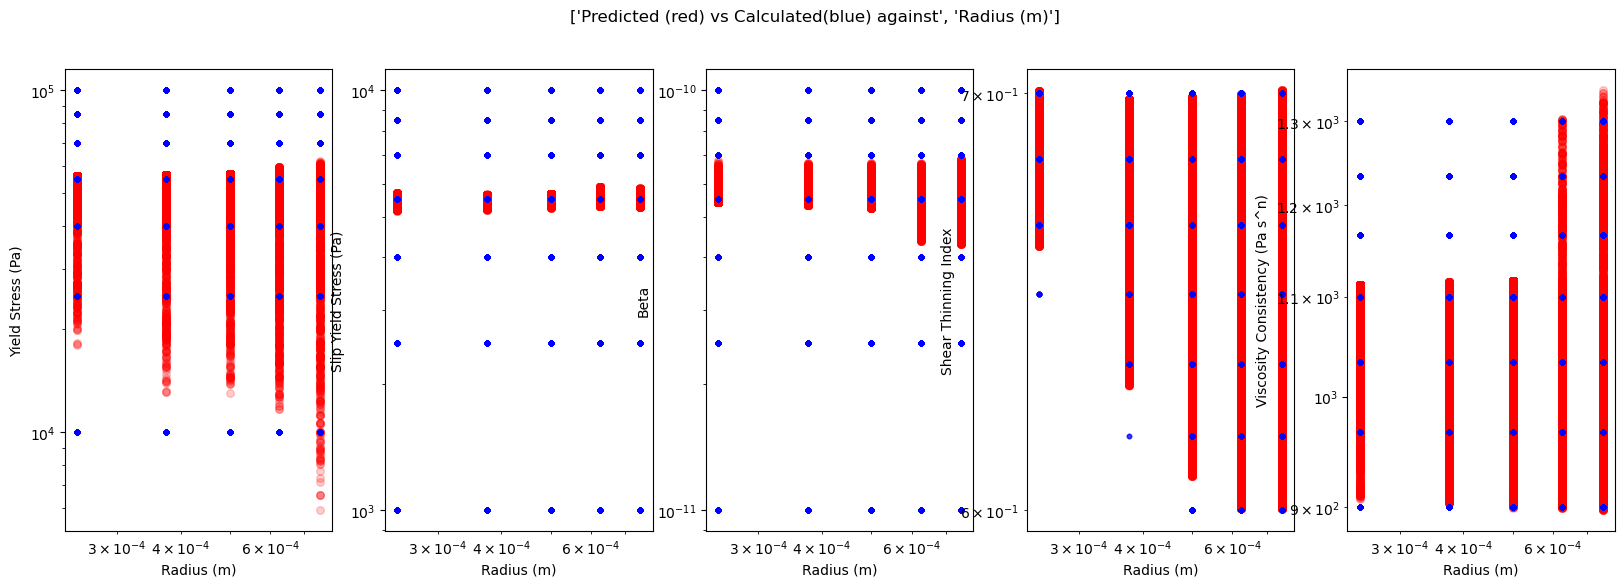

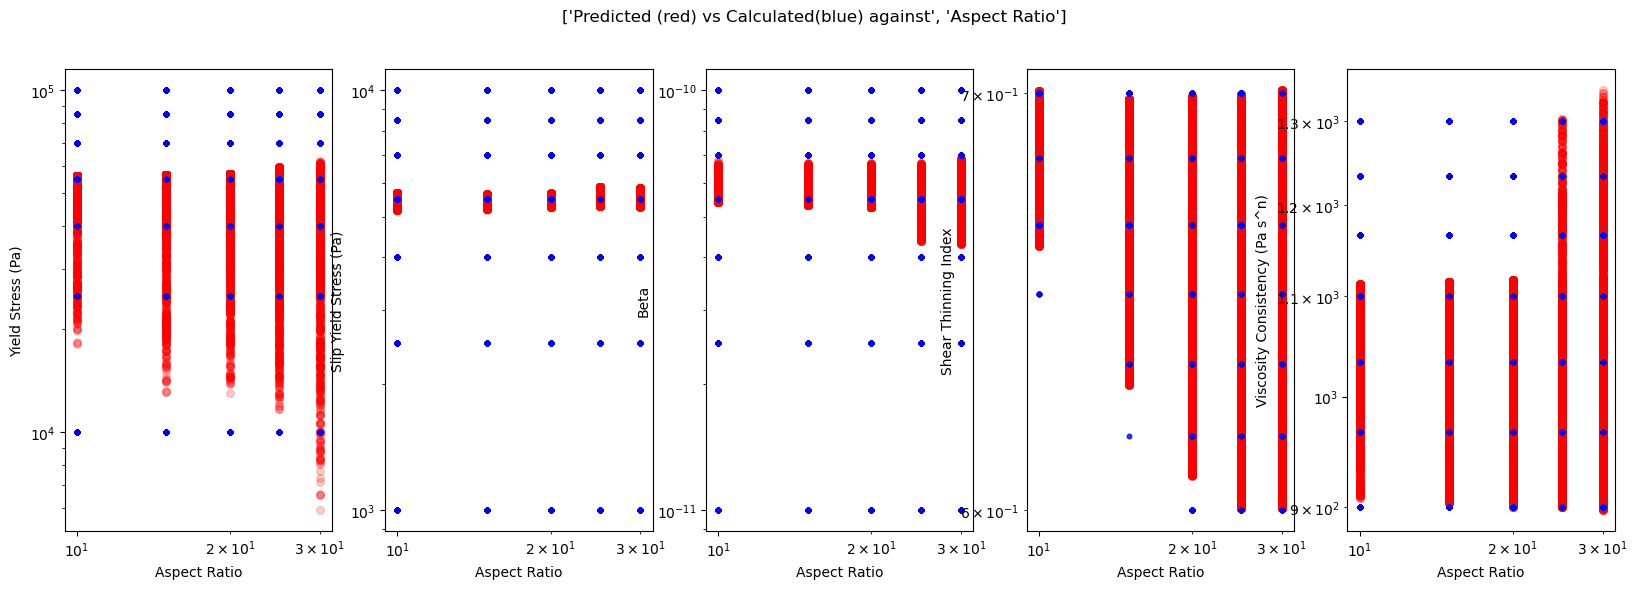

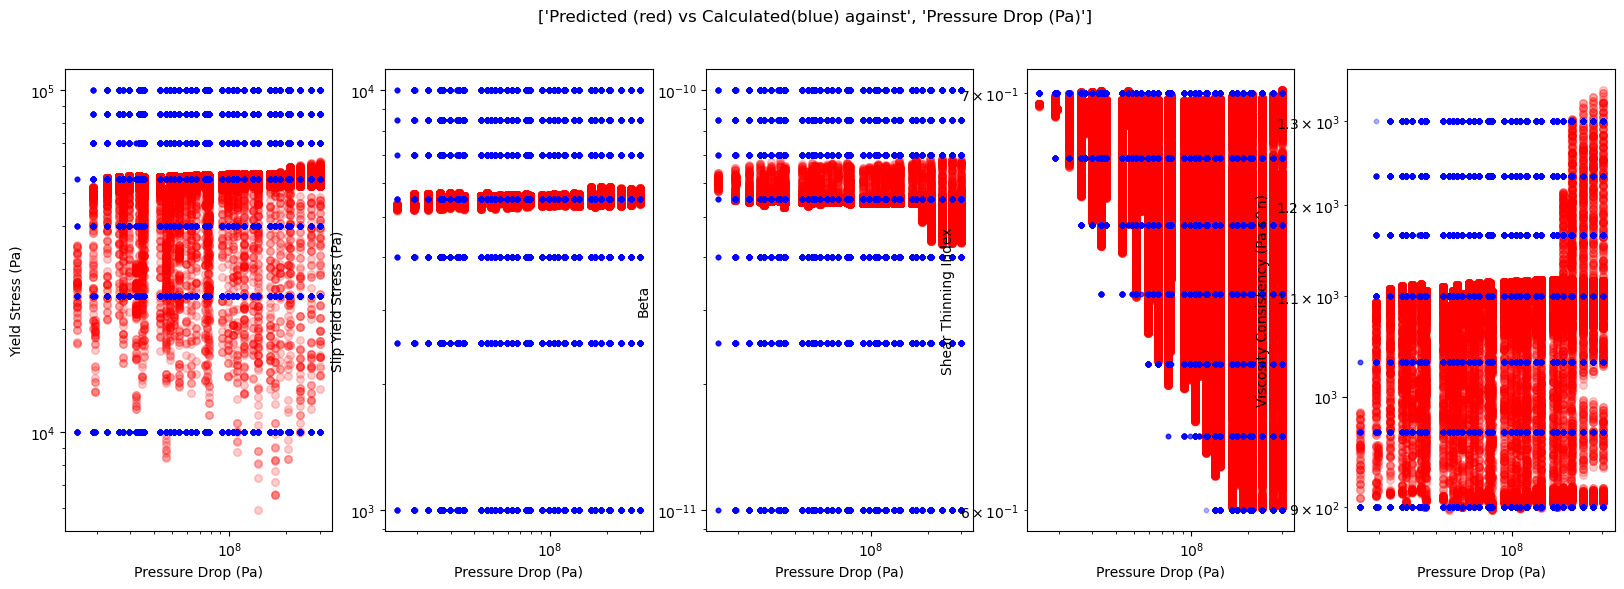

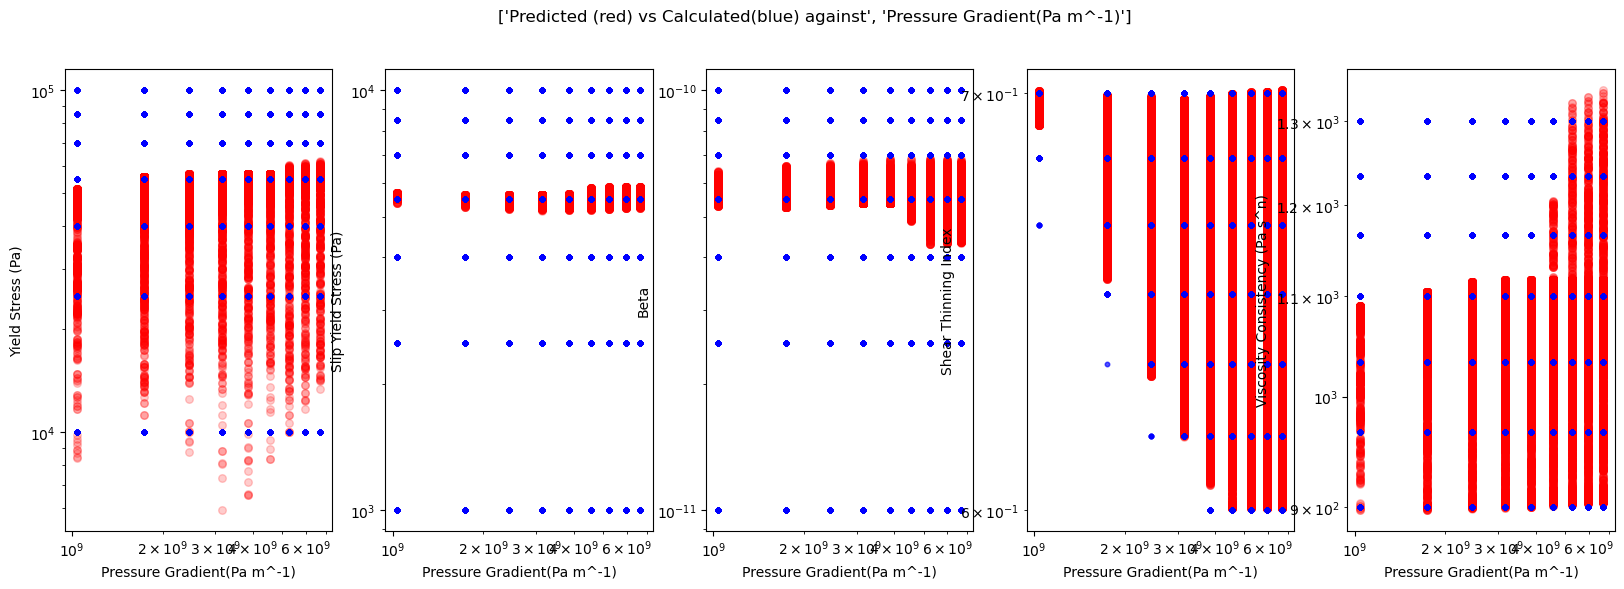

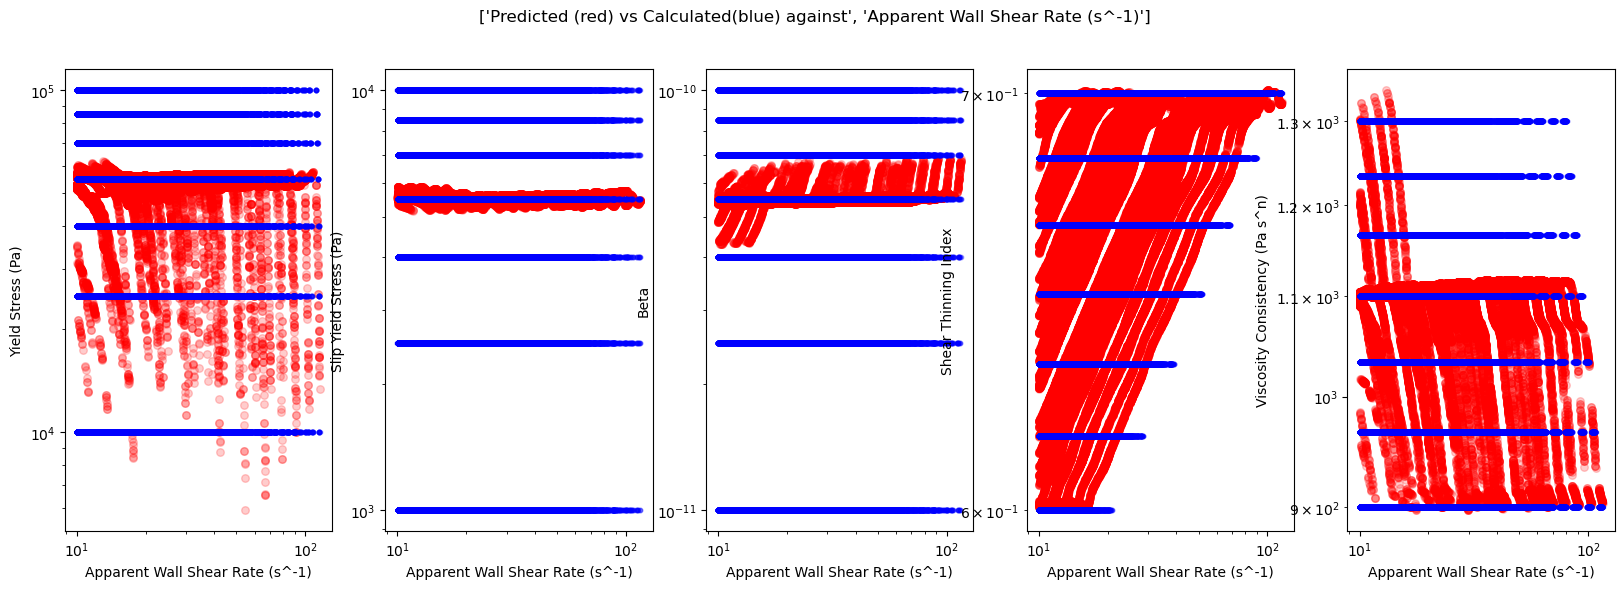

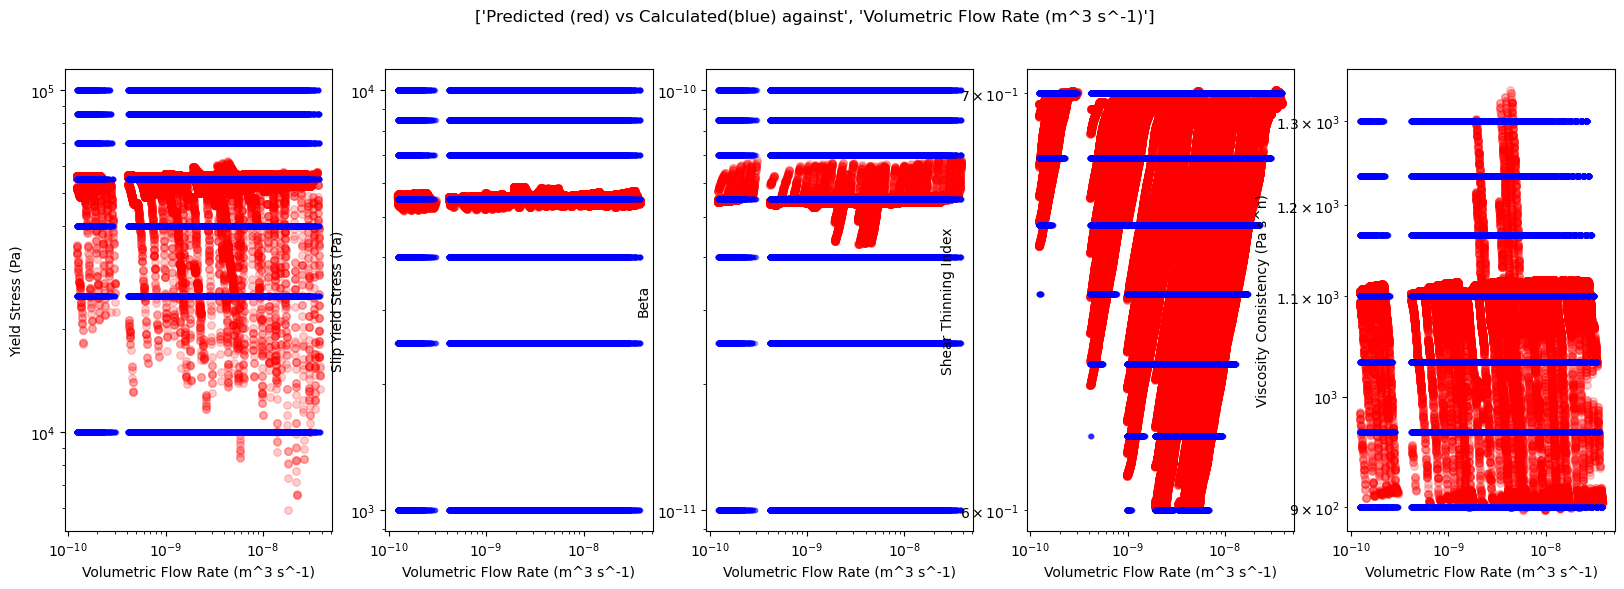

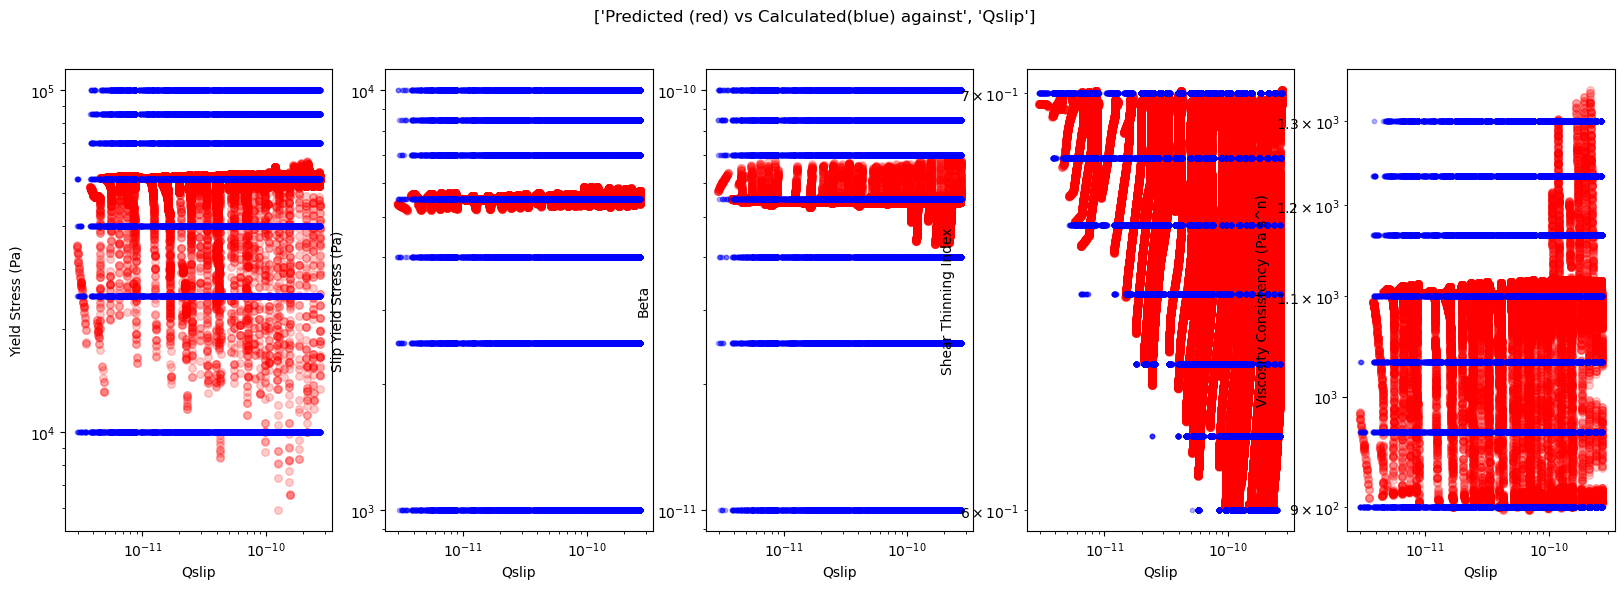

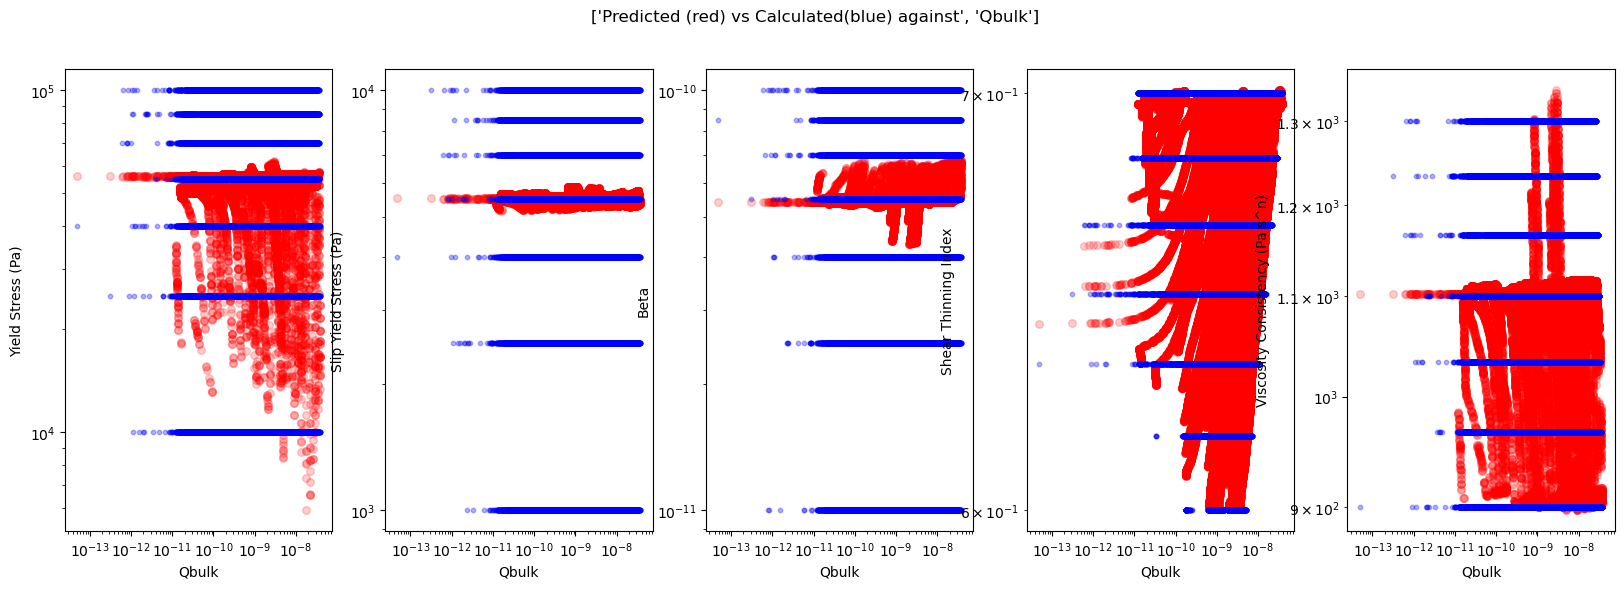

In [149]:
for k in range(8):
    fig, axs = plt.subplots(1, 5, figsize=(20, 6))
    for i in range(5):
        axs[i].scatter(X_test_df_2[:, k], y_pred_df_2[:, i], alpha = 0.2, label = 'Predicted', color = 'red', s=30)
        axs[i].scatter(X_test_df_2[:, k], y_test_df_2[:, i], alpha = 0.3, label = 'Calculated', color = 'blue', s=10)
        axs[i].set_ylabel(Target_Values_2.columns[i])
        axs[i].set_xlabel(Theoretical_data_2.columns[k])
        axs[i].set_yscale('log')
        axs[i].set_xscale('log')
    fig.suptitle(['Predicted (red) vs Calculated(blue) against', Theoretical_data_2.columns[k]])